# Predicting NMR Spectra on a Quantum Computer

This tutorial demonstrates how to simulate liquid‑state 1H NMR spectra of molecules using Qiskit. We map an N‑spin NMR Hamiltonian to qubit operators, perform Trotterized time evolution, evaluate total transverse magnetization with Estimator primitives, and recover the frequency‑domain spectrum via a Fourier transform. As an illustrative example of a molecule, the following figures shows cis‑3‑chloroacrylic acid.

<div style="display:flex; gap:12px; align-items:flex-start;">
  <img src="files/images/bmse000368.png" alt="Example molecule (structural formula)" style="height:260px; width:auto; object-fit:contain;">
  <img src="files/images/bmse000368_s.png" alt="Example molecule (skeletal drawing)" style="height:260px; width:auto; object-fit:contain;">
</div>

Example system: cis‑3‑chloroacrylic acid has three hydrogens ($C_3H_3ClO_2$). The acidic OH proton typically exchanges with D2O and is not observed, leaving two vinylic protons on the C=C bond that generate two distinct 1H NMR signals split by their mutual J coupling. In this notebook we treat the observed protons as an N‑spin network and keep the workflow general so you can substitute any molecule with N observed 1H spins.

## What this notebook does
1. Loads an N‑spin NMR Hamiltonian (struqture format), selectable by molecule.
2. Applies a rotating‑frame shift by subtracting the mean Zeeman term to enable stable Trotter steps.
3. Converts the N‑spin Hamiltonian to Qiskit’s SparsePauliOp.
4. Constructs first‑order (and optionally higher‑order) Trotter circuits for N‑spin time evolution
5. Prepare the initial state and measurement operator needed for time-evolution.
6. Uses Estimator V2 (Qiskit 2.2.x) with a statevector backend to obtain expectation values.
7. Computes the spectrum from time‑domain signals and applies a Fourier transform.


## Where to find more information
The derivation of the NMR spectra is quite evolved. If you are interested, you can follow the links below where you can find more information on the NMR spectrum. This is however not needed to solve the task. 

- The documentation of HQS Spectrum Tools explains the derivation of the 1D NMR spectrum:
  https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/index.html
- The derivation of NMR spectrum simulation on a quantum computer is discussed in:
  - A. Khedri et al., The impact of noise on the simulation of NMR spectroscopy on NISQ devices, arXiv:2404.18903 (2024), https://arxiv.org/abs/2404.18903
- This notebook demonstrates the calculation for cis‑3‑chloroacrylic acid, and many more molecules are available on HQStage in the HQS NMR Parameters database (part of HQS Spectrum Tools):
  https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/molecular_data.html

## Data sources and references for molecular NMR parameters
The notebook comes with 3 molecules that have 2 spins (cis‑3‑chloroacrylic acid), 5 spins (C6H5NO2) and 12 spins (exo‑dicyclopentadiene_DFT). These references to the molecule are:

- Cis‑3‑chloroacrylic acid (bmse000368)
  - Description: “NMR parameters for molecule ‘Cis‑3‑chloroacrylic‑acid’ from bmse000368 entry. The data is available at: https://gissmo.bmrb.io/entry/bmse000368/simulation_1”

- Nitrobenzene (C6H5NO2)
  - Description: “1H parameters for nitrobenzene. Values were obtained from Hans Reich’s Collection, NMR Spectroscopy. https://organicchemistrydata.org”

- exo‑dicyclopentadiene_DFT
  - Description: “1H parameters calculated with DFT. The geometry was optimized with B97‑3c in chloroform (CPCM). Shieldings were calculated with PBE0/pcSseg‑2 in vacuum. Shifts were calculated by subtracting the respective shieldings from the computed shielding of TMS. J‑couplings were calculated with PBE/pcJ‑2 in vacuum.”

In [46]:
# Run this cell once to install the required packages for local/Aer simulation.
# Notes:
# - ipykernel is optional; install it if you want this environment as a Jupyter kernel.

%pip install -q "qiskit>=2.2,<3" struqture_py numpy scipy matplotlib ipykernel

Note: you may need to restart the kernel to use updated packages.


In [47]:
from struqture_py.spins import PauliHamiltonian
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

# NEW imports for Qiskit 2.2.x
from qiskit.primitives import StatevectorEstimator as Estimator

import matplotlib.pyplot as plt
from itertools import product
import json
import numpy as np
from pathlib import Path
import pickle
from typing import Tuple, Any
import re

## 1. N‑spin NMR Hamiltonian

We model an arbitrary N‑spin 1H network in liquid state. The Hamiltonian is:

$$
\hat H \;=\; -\sum_{\ell=1}^{N}\gamma_\ell\!\left(1+\delta_\ell\right) B_z\, \hat I_\ell^{\,z}
\;+\; 2\pi \sum_{k<\ell} J_{k\ell}\; \hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell
$$

$$
\hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell \;=\; \hat I_k^{\,x}\hat I_\ell^{\,x}+\hat I_k^{\,y}\hat I_\ell^{\,y}+\hat I_k^{\,z}\hat I_\ell^{\,z}
$$

The parameters are:

- Gyromagnetic ratio (rad·s⁻¹·T⁻¹):
  $ \gamma_\ell $
  (For 1H: $ \gamma / 2\pi \approx 42.577\ \text{MHz/T} $)

- Chemical shift (dimensionless, reported in ppm):
  $ \delta_\ell $

- Static magnetic field along z (T):
  $ B_z $

- Isotropic scalar coupling between spins k and ℓ (Hz):
  $ J_{k\ell} $

- Spin operators (dimensionless) with components α in {x, y, z}:
  $ \hat I_k^{\alpha} $

- Shifted Larmor angular frequency for spin ℓ:
  $ \omega_\ell $

By default, this notebook loads the liquid‑state spin Hamiltonian for the molecule cis‑3‑chloroacrylic_acid_exp at a static magnetic field: $ B_0 = 11.7433\ \text{T} $ applied along z. The Hamiltonian is stored as JSON produced by `struqture_py` (see also the documentation of struqture: https://hqsquantumsimulations.github.io/struqture/).

At the end of the following cell, we print the `PauliHamiltonian`. The terms in struqture mean:

- The object is a sparse sum of Pauli strings with real coefficients. A key like `0Z`, `1Z`, or `0X1X` identifies which Pauli operator acts on which spin index:
  - `iZ` means a Z operator on spin index i (e.g., 0 or 1).
  - `0X1X` means X on spin 0 and X on spin 1 (tensor product X ⊗ X). Similarly, `0Y1Y` and `0Z1Z` are Y ⊗ Y and Z ⊗ Z between spins 0 and 1.

In [ ]:
# Folder that contains the Hamiltonian JSON files.
data_dir = Path("files")

# Name of the molecule.
molecule_name = "bmse000368"  # 2 spins
# molecule_name = "C6H5NO2" # 5 spins
# Note: Setting 12 spins on current notebooks takes considerable time.
# molecule_name = "exo-dicyclopentadiene_DFT"  # 12 spins

# Magnetic field
field_T = 11.7433

# Build full filename.
filename = data_dir / f"{molecule_name}_B{field_T}T.json"

# Open JSON file.
with open(filename, "r") as json_file:
    hamiltonian_json = json.load(json_file)

# Create PauliHamiltonian from JSON file.
hamiltonian_struqture = PauliHamiltonian.from_json(hamiltonian_json)

# Get the number of spins in the Hamiltonian.
number_spins = hamiltonian_struqture.current_number_spins()

# Note that the energies of 0Z and 1Z and 2 to 3 orders of magnetic larger than the coupling.
print("Struqture Hamiltonian:\n", hamiltonian_struqture)

Struqture Hamiltonian:
 PauliHamiltonian{
0Z: -1.1875220049858091e4,
1Z: -1.2927653572559357e4,
2Z: -1.2927653572559357e4,
3Z: -1.1875220049858091e4,
4Z: -1.2110839495420456e4,
0X1X: 1.3194689145077133e1,
0Y1Y: 1.3194689145077133e1,
0Z1Z: 1.3194689145077133e1,
0X2X: 9.42477796076938e-1,
0Y2Y: 9.42477796076938e-1,
0Z2Z: 9.42477796076938e-1,
0X3X: 2.356194490192345e0,
0Y3Y: 2.356194490192345e0,
0Z3Z: 2.356194490192345e0,
0X4X: 1.1780972450961723e1,
0Y4Y: 1.1780972450961723e1,
0Z4Z: 1.1780972450961723e1,
1X2X: 3.769911184307752e0,
1Y2Y: 3.769911184307752e0,
1Z2Z: 3.769911184307752e0,
1X3X: 9.42477796076938e-1,
1Y3Y: 9.42477796076938e-1,
1Z3Z: 9.42477796076938e-1,
1X4X: 1.884955592153876e0,
1Y4Y: 1.884955592153876e0,
1Z4Z: 1.884955592153876e0,
2X3X: 1.3194689145077133e1,
2Y3Y: 1.3194689145077133e1,
2Z3Z: 1.3194689145077133e1,
2X4X: 1.884955592153876e0,
2Y4Y: 1.884955592153876e0,
2Z4Z: 1.884955592153876e0,
3X4X: 1.1780972450961723e1,
3Y4Y: 1.1780972450961723e1,
3Z4Z: 1.1780972450961723e1,
}

## 2. Rotating‑frame shift: subtracting the mean Z term

We subtract the mean Z (Zeeman) term to remove the large common Larmor precession so the effective Hamiltonian has a smaller scale. Our rough stability estimate for Trotterized evolution is:

$ \lVert H_{\max}\rVert \,\Delta t \;<\; 1 \quad (\Delta t = \text{trotter\_timestep}) $

Keeping this product small reduces first‑order Trotter error, which grows with both step size and operator magnitudes. By shrinking the effective
$ \lVert H_{\max}\rVert $
via the rotating‑frame shift, we achieve smaller Trotter error for the same
$ \Delta t $.

In [49]:
# We are now extracting the single-qubit Z terms from the full Hamiltonian:
z_terms = []
for i in range(number_spins):
    z_terms.append(hamiltonian_struqture.get(f"{i}Z"))

# Mean of Z terms.
mean_z_parameter = np.mean(z_terms)

# Setting the chemical shift due to rotating frame of the QC calculation:
chemical_shift_hz = mean_z_parameter / (2 * np.pi)

# We now subtract the mean value of the Z coupling from the full Hamiltonian
# to arrive at the Hamiltonian that is used in the NMR calculation and store the second
# chemical shift we need to apply to the spectrum at the end.
correction_hamiltonian = PauliHamiltonian()
for i in range(number_spins):
    correction_hamiltonian.set(f"{i}Z", mean_z_parameter)

hamiltonian_struqture = hamiltonian_struqture - correction_hamiltonian

# In the rotating frame, the energies are all of order 1.
print("Hamiltonian in rotating frame: \n", hamiltonian_struqture)

Hamiltonian in rotating frame: 
 PauliHamiltonian{
0Z: 4.68097298192979e2,
1Z: -5.843362245082863e2,
2Z: -5.843362245082863e2,
3Z: 4.68097298192979e2,
4Z: 2.324778526306145e2,
0X1X: 1.3194689145077133e1,
0Y1Y: 1.3194689145077133e1,
0Z1Z: 1.3194689145077133e1,
0X2X: 9.42477796076938e-1,
0Y2Y: 9.42477796076938e-1,
0Z2Z: 9.42477796076938e-1,
0X3X: 2.356194490192345e0,
0Y3Y: 2.356194490192345e0,
0Z3Z: 2.356194490192345e0,
0X4X: 1.1780972450961723e1,
0Y4Y: 1.1780972450961723e1,
0Z4Z: 1.1780972450961723e1,
1X2X: 3.769911184307752e0,
1Y2Y: 3.769911184307752e0,
1Z2Z: 3.769911184307752e0,
1X3X: 9.42477796076938e-1,
1Y3Y: 9.42477796076938e-1,
1Z3Z: 9.42477796076938e-1,
1X4X: 1.884955592153876e0,
1Y4Y: 1.884955592153876e0,
1Z4Z: 1.884955592153876e0,
2X3X: 1.3194689145077133e1,
2Y3Y: 1.3194689145077133e1,
2Z3Z: 1.3194689145077133e1,
2X4X: 1.884955592153876e0,
2Y4Y: 1.884955592153876e0,
2Z4Z: 1.884955592153876e0,
3X4X: 1.1780972450961723e1,
3Y4Y: 1.1780972450961723e1,
3Z4Z: 1.1780972450961723e1,
}


## 3. Convert Struqture Hamiltonian to Qiskit

In [50]:
def struqture_hamiltonian_to_qiskit_op(
    ham_struqture: PauliHamiltonian,
    n_qubits: int,
    reverse_qubit_order: bool = True,
) -> SparsePauliOp:
    """
    Convert struqture PauliHamiltonian keys like '0Z', '10X11X' into Qiskit labels.

    Args:
        ham_struqture (PauliHamiltonian): struqture Hamiltonian to transform to Qiskit
        n_qubits (int): number of qubits in the Hamiltonian
        reverse_qubit_order (bool): makes Qiskit's rightmost char qubit 0 (little-endian).
    """
    labels = []
    coeffs = []
    token_re = re.compile(r"(\d+)([XYZ])")

    for key, val in zip(ham_struqture.keys(), ham_struqture.values()):
        s = str(key)  # e.g., '0Z', '0X1X', '10X11X'
        pauli = ["I"] * n_qubits
        if s != "I":
            for m in token_re.finditer(s):
                idx = int(m.group(1))  # site index (can be multi-digit)
                op = m.group(2)  # 'X', 'Y', or 'Z'
                q = (n_qubits - 1 - idx) if reverse_qubit_order else idx
                if not (0 <= q < n_qubits):
                    raise IndexError(
                        f"Site index {idx} (mapped to qubit {q}) out of range 0..{n_qubits-1}"
                    )
                pauli[q] = op
        labels.append("".join(pauli))
        coeffs.append(complex(val))

    return SparsePauliOp(labels, coeffs)

In [51]:
hamiltonian_qiskit = struqture_hamiltonian_to_qiskit_op(hamiltonian_struqture, number_spins)

# Qiskit representation of the Hamiltonian.
print("Hamiltonian in Qiskit:\n", hamiltonian_qiskit)

Hamiltonian in Qiskit:
 SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIXX', 'IIIYY', 'IIIZZ', 'IIXIX', 'IIYIY', 'IIZIZ', 'IXIIX', 'IYIIY', 'IZIIZ', 'XIIIX', 'YIIIY', 'ZIIIZ', 'IIXXI', 'IIYYI', 'IIZZI', 'IXIXI', 'IYIYI', 'IZIZI', 'XIIXI', 'YIIYI', 'ZIIZI', 'IXXII', 'IYYII', 'IZZII', 'XIXII', 'YIYII', 'ZIZII', 'XXIII', 'YYIII', 'ZZIII'],
              coeffs=[ 468.09729819+0.j, -584.33622451+0.j, -584.33622451+0.j,
  468.09729819+0.j,  232.47785263+0.j,   13.19468915+0.j,
   13.19468915+0.j,   13.19468915+0.j,    0.9424778 +0.j,
    0.9424778 +0.j,    0.9424778 +0.j,    2.35619449+0.j,
    2.35619449+0.j,    2.35619449+0.j,   11.78097245+0.j,
   11.78097245+0.j,   11.78097245+0.j,    3.76991118+0.j,
    3.76991118+0.j,    3.76991118+0.j,    0.9424778 +0.j,
    0.9424778 +0.j,    0.9424778 +0.j,    1.88495559+0.j,
    1.88495559+0.j,    1.88495559+0.j,   13.19468915+0.j,
   13.19468915+0.j,   13.19468915+0.j,    1.88495559+0.j,
    1.88495559+0.j,    1.88495559+0.j,   11.

## 4. Quantum circuit for Trotterized time evolution

In the following we create the Trotter circuit, the measurement operators and the initial circuit, that we need for the time-evolution. Your task will be to create the initial circuits.

Understanding where the equations for the NMR correlation come from, is a rather complicated task. If you are interested you can follow along the references:

- HQS Spectrum Tools (derivation of the expectation values): https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/background/math.html
- A. Khedri et al., The impact of noise on the simulation of NMR spectroscopy on NISQ devices, arXiv:2404.18903 (2024): https://arxiv.org/abs/2404.18903


However, you only need to understand the relevant equations which we explain here. The two important expectation values that we need to calculate to get the NMR spectra are
<!-- 
The expectation value, the is measurement in an NMR experiment is 
$$
\big\langle \gamma_k\, \hat I_k^{x} \big\rangle (t)\;\propto\; \mathrm{Tr}\!\left( \hat I_k^{x}\, e^{-i \hat H t}\, \hat I_{\ell}^{y}\, e^{+i \hat H t} \right).
$$ -->

$$
C_{xx}(t) \;=\; \mathrm{Tr}\!\big( \hat I_{x}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big), 
\qquad
C_{yx}(t) \;=\; \mathrm{Tr}\!\big( \hat I_{y}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big).
$$

$I_{x, y}^{\mathrm{tot}}(t)$ are the total magnetization is $x$ and $y$ direction, respectively. Note already that these expressions are not expectation value of a single operator (that can be calculated directly on a quantum computer). Therefore, we still have to do a small intermediate step: 

1) Let $\{\lvert m_{x,n}(0)\rangle\}_{n=1}^{2^N} $ be a complete set of eigenstates of $ \hat I_x^{\mathrm{tot}}(0) $ (the right operator in both $C_{xx}(t) $ and $C_{yx}(t) $) with eigenvalues $ m_{x,n}(0) $ (i.e., $ \hat I_x^{\mathrm{tot}}(0)\lvert m_{x,n}(0)\rangle = m_{x,n}(0)\lvert m_{x,n}(0)\rangle $).

2) Insert the identity
$ \mathbb{1}=\sum_{n}\lvert m_{x,n}(0)\rangle\langle m_{x,n}(0)\rvert $
into the trace.

3) Using linearity and the eigenvalue equation:
$$
\begin{aligned}
\mathrm{Tr}\!\big( \hat I_{\alpha}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big)
&= \sum_{n=1}^{2^N} \mathrm{Tr}\!\Big( \hat I_{\alpha}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\, \lvert m_{x,n}(0)\rangle\langle m_{x,n}(0)\rvert \Big) \\
&= \sum_{n=1}^{2^N} \mathrm{Tr}\!\Big( \hat I_{\alpha}^{\mathrm{tot}}(t)\, m_{x,n}(0)\, \lvert m_{x,n}(0)\rangle\langle m_{x,n}(0)\rvert \Big) \\
&= \sum_{n=1}^{2^N} m_{x,n}(0)\, \langle m_{x,n}(0)\rvert \hat I_{\alpha}^{\mathrm{tot}}(t)\lvert m_{x,n}(0)\rangle,
\end{aligned}
$$
with
$ \alpha\in\{x,y\}. $ This expression can be directly calculate on a quantum computer!
<!-- 
4) Writing
$ \lvert m_{x,n}(t)\rangle = e^{-iHt}\lvert m_{x,n}(0)\rangle $
yields the commonly used form:
$$
\mathrm{Tr}\!\big( \hat I_{\alpha}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big)
\;=\;
\sum_{n=1}^{2^N} m_{x,n}(0)\, \langle m_{x,n}(t)\,|\, \hat I_{\alpha}^{\mathrm{tot}}\,|\, m_{x,n}(t)\rangle.
$$ -->
However, there are some difficulties with the approach: The sum runs over all
$ 2^N $ X‑basis product states, which form a complete basis for the N‑spin Hilbert space. In the intermediate track your task will be to create all initial states of the $|m_{x,n}\rangle$ of the $I_{x}^{\mathrm{tot}}$ operator. In the advanced track we deal with the exponential number of initial states.

On a quantum computer, we will:
- Prepare eigenstates of
  $ \hat I_x^{\mathrm{tot}} $
  (product states in the X‑basis) across the N spins.
- Evolve under the rotating‑frame Hamiltonian using a Trotterized unitary
  $ U(\Delta t)=e^{-i \hat H \Delta t} $
  repeated for the chosen number of steps.
- At each step, estimate
  $ \langle \hat I_x^{\mathrm{tot}}(t)\rangle $
  and
  $ \langle \hat I_y^{\mathrm{tot}}(t)\rangle $
  (e.g., with Estimator V2) to assemble
  $ C_{xx}(t) $
  and
  $ C_{yx}(t) $.

Finally we apply a small damping and Fourier transform to obtain the spectrum.

### 4.1 Trotter circuit

In [52]:
# Default number of Trottersteps.
number_of_trottersteps = 100

# Default Trotter timestep.
trotter_timestep = 0.01

if molecule_name == "bmse000368":
    number_of_trottersteps = 100
    trotter_timestep = 0.01
elif molecule_name == "C6H5NO2":
    number_of_trottersteps = 200
    trotter_timestep = 0.002
elif molecule_name == "exo-dicyclopentadiene_DFT":
    trotter_timestep = 0.0002


# Trotter Circuit
trotter_step_first_order = PauliEvolutionGate(
    hamiltonian_qiskit, trotter_timestep, synthesis=LieTrotter()
)

circuit = QuantumCircuit(hamiltonian_qiskit.num_qubits)
circuit.append(trotter_step_first_order, range(hamiltonian_qiskit.num_qubits))
circuit = circuit.decompose(reps=1)

print("Trotter circuit: \n", circuit)

Trotter circuit: 
       ┌────────────┐┌────────────────┐┌────────────────┐               »
q_0: ─┤ Rz(1.8724) ├┤0               ├┤0               ├─■─────────────»
     ┌┴────────────┤│  Rxx(0.052779) ││  Ryy(0.052779) │ │ZZ(0.052779) »
q_1: ┤ Rz(-2.3373) ├┤1               ├┤1               ├─■─────────────»
     ├─────────────┤└────────────────┘└────────────────┘               »
q_2: ┤ Rz(-2.3373) ├───────────────────────────────────────────────────»
     └┬────────────┤                                                   »
q_3: ─┤ Rz(1.8724) ├───────────────────────────────────────────────────»
     ┌┴────────────┤                                                   »
q_4: ┤ Rz(0.92991) ├───────────────────────────────────────────────────»
     └─────────────┘                                                   »
«     ┌─────────────────┐┌─────────────────┐                                 »
«q_0: ┤0                ├┤0                ├─■───────────────────────────────»
«     │             

### 4.2 To-Do: Initial State
Goal: initialize the N‑spin register in eigenstates of the total X‑magnetization operator so we can build correlation functions in the X basis.

$$
\hat I_x^{\mathrm{tot}} \;=\; \sum_{i=1}^{N} \hat I_i^{\,x}
$$

How to prepare (at a high level): use any state‑preparation method you like that produces X‑basis product states on each qubit. You can implement this with a parameterized template that toggles each spin between the plus and minus X eigenstate.


In [54]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp


def xsum_eigenstate_template(n_qubits: int):
    """Parameterized prep for any eigenstate of sum_i X_i.
    Set phi[i]=0 for |+>, phi[i]=pi for |-> on qubit i.
    """
    phi = ParameterVector("phi", n_qubits)
    qc = QuantumCircuit(n_qubits, name="XsumEigen")
    for q in range(n_qubits):
        qc.ry(np.pi / 2, q)  # |0> -> |+>
        qc.rz(phi[q], q)  # 0 keeps |+>, pi -> |-> (global phase irrelevant)
    return qc, phi



# --- your parametric initial-state template ---
# qc_init_template has Parameters phi[0..n-1] (0 -> |+>, pi -> |->)
qc_init_template, phi = xsum_eigenstate_template(number_spins)  # from your first snippet


# Enumerate all initial states as bitstrings (0 -> |+>, 1 -> |->) and parameter maps
bits_list = list(product([0, 1], repeat=number_spins))
param_maps = []
for bits in bits_list:
    vals = [np.pi if b else 0.0 for b in bits]
    bind = {phi[i]: vals[i] for i in range(number_spins)}  # map each Parameter to a value
    param_maps.append(bind)

### 4.3 Observables

To reconstruct the spectrum in the rotating frame, we need the transverse magnetization in both $x$ and $y$ directions. Total transverse operators
$$
\hat I_{x/y}^{\rm tot}=\sum_k \hat I_k^{\,x/y}
$$
What we record each time step is
$
\langle \hat I_x^{\rm tot}(t)\rangle 
$
and 
$
\langle \hat I_y^{\rm tot}(t)\rangle \, .
$

These two signals provide the time-dependent expectation values used in the Fourier transform ($C_{xx}(t) $ and $C_{yx}(t)$ ).

In [55]:
obs_x = SparsePauliOp.from_sparse_list(
    [("X", [i], 1.0) for i in range(number_spins)], num_qubits=number_spins
)
obs_y = SparsePauliOp.from_sparse_list(
    [("Y", [i], 1.0) for i in range(number_spins)], num_qubits=number_spins
)

### 4.4 Simulation with Qiskit's *Estimator*

In this step we use one of the backends in qiskit to perform a Trotterized time-evolution and find the time dependence of total magnetization for our system of interest.

In [56]:
# Prebuild the parametric circuit at each step: U^n composed after the init template.
circuits_per_step = []
c = QuantumCircuit(number_spins)
c = c.compose(qc_init_template)  # still parametric in phi
circuits_per_step.append(c)

for _ in range(1, number_of_trottersteps):
    c = c.compose(circuit)  # append one more Trotter step
    circuits_per_step.append(c)

number_of_initializations = len(bits_list)
exp_x = np.zeros((number_of_initializations, number_of_trottersteps))
exp_y = np.zeros((number_of_initializations, number_of_trottersteps))

estimator = Estimator()

# Batch all initial states for each step to minimize overhead
for k, circ in enumerate(circuits_per_step):
    pubs = []
    for m in range(number_of_initializations):
        pubs.append((circ, [obs_x, obs_y], param_maps[m]))  # pass parameter_values per pub
    job = estimator.run(pubs)
    results = job.result()  # list-like; one result per pub
    for m, res in enumerate(results):
        evs = res.data.evs  # [⟨obs_x⟩, ⟨obs_y⟩]
        exp_x[m, k] = evs[0]
        exp_y[m, k] = evs[1]

In [68]:
from qiskit.primitives import BaseEstimatorV2, StatevectorEstimator

Above we calculate the expectation value for every spins. Now we have to sum over all spins. Additionally we add $0$ to increase the resolution of the spectrum.

\begin{equation*}
\mathrm{Tr}\!\big( \hat I_{x/y}^{\rm tot}(t)\, \hat I_x^{\rm tot}(0)\big)
\;=\;
\sum_{n} m_{x,n}(0)\, \langle m_{x,n}(t)\,|\, \hat I_{x/y}^{\rm tot}\,|\, m_{x,n}(t)\rangle,
\end{equation*}

In [57]:
# Expectation values.
c_xx = np.zeros(number_of_trottersteps)
c_yx = np.zeros(number_of_trottersteps)

# Perform vectorized calculations
mx_0 = exp_x[:, 0]
for i in range(number_of_trottersteps):
    c_xx[i] = np.sum(mx_0 * exp_x[:, i], axis=0)
    c_yx[i] = np.sum(mx_0 * exp_y[:, i], axis=0)

# --- apply a single exponential window before FFT ---
noise_strength = 3.0  # s^-1 (choose per system/step size)
times = np.arange(number_of_trottersteps) * trotter_timestep
window = np.exp(-noise_strength * times)
c_xx = c_xx * window
c_yx = c_yx * window

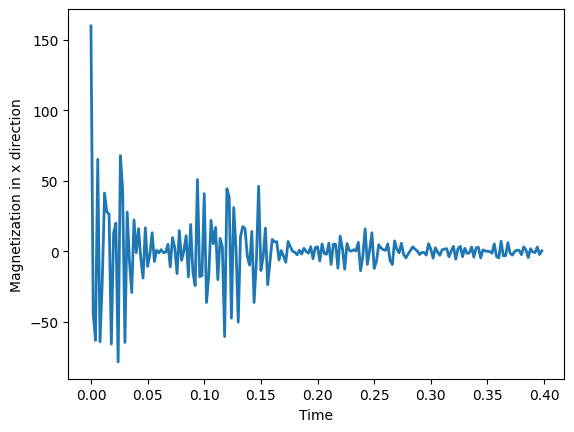

In [58]:
plt.figure(dpi=100)
plt.plot(times, c_xx, color="C0", lw=2.0)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Magnetization in x direction", fontsize=10)
plt.show()

## 5. Finding the Spectrum

In this step, we perform a Fourier transform of the correlation functions to find the spectrum (a detailed derivation fo the spectral function can be found in the paper [arXiv:2404.18903](https://arxiv.org/abs/2404.18903))

$$
S(\omega)
\;=\;
\,\mathrm{Re}\!\int_{0}^{\infty} \! dt\; e^{-i(\omega-\bar\omega)t - \Gamma t}\,
\mathrm{Tr} \left( \hat I_x^{\rm tot}(t)\,\hat I_x^{\rm tot}(0) \right)
\;-\;
\,\mathrm{Im}\!\int_{0}^{\infty} \! dt\; e^{-i(\omega-\bar\omega)t - \Gamma t}\,
\mathrm{Tr} \left( \hat I_y^{\rm tot}(t)\,\hat I_x^{\rm tot}(0) \right).
$$

where $\Gamma$ is the effective decoherence rate that physically arises due to the interaction of nuclear spin with its environment or simply an artificial decay to perform the Fourier transform.

In [59]:
def time_signal_to_spectrum(
    c_xx: np.ndarray,
    c_yx: np.ndarray,
    trotter_timestep: float,
    number_of_trottersteps: int,
    Hz_to_ppm_conversion: float,
    chem_shift_hz: float,
) -> Tuple[np.ndarray[Any, Any], np.ndarray[Any, Any]]:
    """Calculate the full spectrum from the computed expectation values via a Fourier Transform.

    Args:
        m_avg_z (np.ndarray): The first expectation value (c_xx)
        m_avg_y (np.ndarray): The second expectation value (c_yx)
        N_max (int): Number of Trotter steps.
        trotter_timestep (float): The Trotter timestep.
        Hz_to_ppm_conversion (float): Conversion factor from frequency to ppm.
        chem_shift_hz (float): The chemical shift of the input Hamiltonian (in Hz).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - **spectrum_full (np.ndarray):** The calculated spectrum.
            - **ppm (np.ndarray):** The ppm array to plot the full spectrum against.
    """
    spectrum_full = np.zeros(c_xx.shape[0], dtype=np.float64)

    m_avg_z = fft_causal(c_xx)
    m_avg_y = fft_causal(c_yx)

    frequencies = np.fft.fftshift(np.fft.fftfreq(number_of_trottersteps, d=trotter_timestep))

    # And now we have the frequency axis in ppm:
    # we need to shift the frequencies by twice the chemical input shift and then by the reference
    # energy, i.e. the energy of the honomuclear isotope (H) times the magnetic field.
    ppm = (frequencies - 2 * chem_shift_hz) * Hz_to_ppm_conversion

    spectrum_full = m_avg_z.real + m_avg_y.imag

    spectrum_full /= np.max(np.abs(spectrum_full))

    return np.abs(spectrum_full), np.asarray(ppm, dtype=float)


def fft_causal(f: np.ndarray) -> np.ndarray:
    """
    Performs the Fourier Transform of a causal signal by separating its even and odd parts.

    Args:
        f (np.ndarray): Input causal signal.

    Returns:
        np.ndarray: The complex Fourier Transform of the causal signal.
    """
    L = len(f)

    # Even part (symmetrize)
    fe = np.zeros(2 * L - 1, dtype=f.dtype)
    fe[:L] = f
    fe[L:] = f[:-1][::-1]
    fe /= 2

    # Odd part (antisymmetrize)
    fo = np.zeros(2 * L - 1, dtype=f.dtype)
    fo[:L] = f
    fo[L:] = -f[:-1][::-1]
    fo /= 2
    fo[0] = 0  # Avoids jump discontinuity at t=0

    # FFT with orthogonal normalization and shift
    fft_even = np.fft.fftshift(np.fft.fft(fe, norm="ortho"))
    fft_odd = np.fft.fftshift(np.fft.fft(fo, norm="ortho"))

    # Combine and downsample to original length
    combined_fft = (fft_even + fft_odd)[::2]

    return combined_fft

In [60]:
# Gyromagnetic ratio for 1H.
GYROMAGNETIC_RATIO_1H_RAD_S_T = 267_522_128.0

# Larmor/reference frequency in Hz at the given field.
reference_energy_hz = GYROMAGNETIC_RATIO_1H_RAD_S_T * field_T / (2 * np.pi)

# Conversion factor to go from Hz to ppm at this field: ppm = (Hz) * (1e6 / v0)
Hz_to_ppm_conversion = 1e6 / reference_energy_hz

In [61]:
spectrum_full, ppm = time_signal_to_spectrum(
    c_xx,
    c_yx,
    trotter_timestep,
    number_of_trottersteps,
    Hz_to_ppm_conversion=Hz_to_ppm_conversion,
    chem_shift_hz=chemical_shift_hz,
)

Reading off the known spectrum obtained via exact diagonalization from json file. You can also use *HQS Spectrum Tools* to calculate the spectrum.

In [62]:
with open(data_dir / f"hqs_spectrum_tools_{molecule_name}_B{field_T}T.pkl", "rb") as f:
    hqs_spectrum_tools_results = pickle.load(f)

hqs_spectrum_tools_ppm = hqs_spectrum_tools_results["frequencies"]
hqs_spectrum_tools_spectrum = hqs_spectrum_tools_results["spectrum"]
hqs_spectrum_tools_spectrum /= np.max(np.abs(hqs_spectrum_tools_spectrum))

Comparing the simulated spectrum with results of HQS Spectrum Tools.

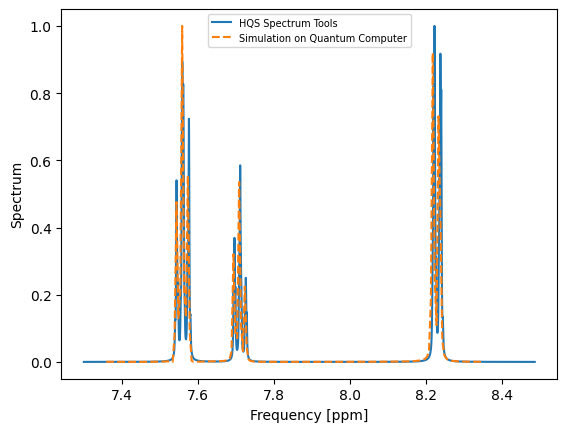

In [63]:
plt.figure(dpi=100)
plt.plot(
    hqs_spectrum_tools_ppm, hqs_spectrum_tools_spectrum, color="C0", label="HQS Spectrum Tools"
)
plt.plot(ppm, spectrum_full, color="C1", ls="--", label="Simulation on Quantum Computer")

plt.xlabel("Frequency [ppm]")
plt.ylabel("Spectrum")
plt.legend(fontsize=7)
plt.show()

In [66]:
import numpy as np

def spectrum_rmse(
    spec_a: np.ndarray, 
    freq_a: np.ndarray,
    spec_b: np.ndarray, 
    freq_b: np.ndarray,
) -> float:
    """
    Compute RMSE between two spectra defined on possibly different frequency axes.

    Parameters
    ----------
    spec_a, freq_a : array-like
        Spectrum A and its frequency axis (Hz or ppm). 1D arrays.
    spec_b, freq_b : array-like
        Spectrum B and its frequency axis (Hz or ppm). 1D arrays.
    return_aligned : bool
        If True, also return the common axis and the aligned spectra used for RMSE.

    Returns
    -------
    rmse : float
        Root-mean-square error on the common axis.
    """
    # determine overlap
    left  = max(freq_a[0],   freq_b[0])
    right = min(freq_a[-1],  freq_b[-1])
    if not (left < right):
        raise ValueError("No overlapping frequency range between the two spectra.")

    # masks inside overlap
    mask_a = (freq_a >= left) & (freq_a <= right)
    mask_b = (freq_b >= left) & (freq_b <= right)
    xa, ya = freq_a[mask_a], spec_a[mask_a]
    xb, yb = freq_b[mask_b], spec_b[mask_b]

    if len(xa) < 2 or len(xb) < 2:
        raise ValueError("Not enough points in the overlap to compare (need at least 2).")

    step = min(np.median(np.diff(xa)), np.median(np.diff(xb)))
    # ensure at least 2 points
    npts = max(2, int(np.floor((right - left) / step)) + 1)
    x_common = np.linspace(left, right, npts)
    A = np.interp(x_common, xa, ya, left=ya[0], right=ya[-1])
    B = np.interp(x_common, xb, yb, left=yb[0], right=yb[-1])

    rmse = float(np.sqrt(np.mean((A - B)**2)))

    return rmse

In [67]:
rmse = spectrum_rmse(    
    hqs_spectrum_tools_spectrum,
    hqs_spectrum_tools_ppm,
    spectrum_full,
    ppm)

print("RMSE:", rmse)
print("RMSE scaled with number spins:", rmse / number_spins**2)

RMSE: 0.07567322798190039
RMSE scaled with number spins: 0.0030269291192760155
